# HSDN Network Project: Sidhant Puntambekar, Behzod Mirpochoev

In [1]:
!git submodule update

In [2]:
!sh scripts/compile_engines.sh
#!cd bipartiteSBM/engines/bipartiteSBM-KL/ && pwd && ls -l

CMake Deprecation Warning at CMakeLists.txt:4 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Performing Test HAVE_STEADY_CLOCK
-- Performing Test HAVE_STEADY_CLOCK -- success
-- Configuring done
-- Generating done
-- Build files have been written to: /Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM/engines/bipartiteSBM-MCMC
Consolidate compiler generated dependencies of target mcmc
[100%] Built target mcmc
/Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM
/Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM


In [3]:
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import networkx as nx
from networkx.algorithms import bipartite

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import random
import copy
import pandas as pd

import biSBM as bm

# Kernighan-Lin inference
from engines.kl import *
from biSBM.ioutils import get_types

# MCMC inference
from biSBM.ioutils import get_edgelist, get_types
from biSBM.optimalks import *
from engines.mcmc import *

# Louvain clustering
import community as community_louvain

# Import copy
import copy # for copy.deepcopy()

%matplotlib inline

In [5]:
# %load bipartiteSBM/tests/test_kl.py
import biSBM as bm


kl = bm.engines.KL(
    f_engine="engines/bipartiteSBM-KL/biSBM",
    n_sweeps=1,
    is_parallel=True,
    n_cores=1,
    kl_edgelist_delimiter="\t",
    kl_steps=5,
    kl_itertimes=1,
    f_kl_output="engines/bipartiteSBM-KL/f_kl_output"
)

edgelist = bm.get_edgelist("dataset/test/southernWomen.edgelist", "\t")
types = bm.get_types("dataset/test/southernWomen.types")

oks = bm.OptimalKs(kl, edgelist, types, default_args=True, random_init_k=False)


def test_answer():
    oks.minimize_bisbm_dl()
    ka = oks.summary()["ka"]
    kb = oks.summary()["kb"]
    assert (ka, kb) == (1, 1)  # there exists no community structure in the southernWomen dataset

test_answer()

# Utility Functions

In [6]:
# Plot CCDF from PS5
def plot_CCDF(kis):
    # from PS5
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

In [7]:
def compute_MGD(G):
    # from PS3
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)

    dij = dict(nx.all_pairs_shortest_path_length(G)) # APSP on G, store as a dictionary (tricky :)

    ells = []                            # list of non-zero and non-infinite lengths
    for node in dij:                     # loop over all the nodes
        temp = list(dij[node].values())  #   get the list of distances
        for length in temp:              #     for each of those distances
            if length>0:                 #     ignore if =0
                ells.append(length)      #     otherwise, add it to ells
                
    ellmean = np.mean(ells)              # MGD = numpy mean of ells list
    return ellmean

In [8]:
def draw_G(G):
    # input : a networkx graph G
    # output: a spring-plot of the network

    print(f'graph with n={G.order()} nodes and m={G.size()} edges:')
    nx.draw_networkx(G,with_labels=True,node_size=600,width=2) # draw it pretty
    limits=plt.axis('off')                                     # turn off axes
    plt.show()
    return

In [9]:
def drawGz(G,z):
    # input  : a graph G and a partition dictionary z
    # output : prints a graph with colored nodes corresponding to groups
    
    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True
    if G.order() > 50:
        nsize  = 100
        flabel = False   
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

# Read In Network and Data Quality Control 

In [10]:
# Read in disease only data 

fname1 = 'sup1.txt'

dfDisease = pd.read_csv(fname1, sep = '\t')
dfDisease

,MeSH Disease Term,PubMed occurrence
0,Breast Neoplasms,122226
1,Hypertension,107294
2,Coronary Artery Disease,82819
3,Lung Neoplasms,78009
4,Myocardial Infarction,75945
...,...,...
4437,Mannosidase Deficiency Diseases,1
4438,White Heifer Disease,1
4439,Tetrasomy,1
4440,Milk Sickness,1


In [11]:
# Read in symptom only data 

fname2 = 'sup2.txt'

dfSymptom = pd.read_csv(fname2, sep = '\t')
dfSymptom

,MeSH Symptom Term,PubMed occurrence
0,Body Weight,147857
1,Pain,103168
2,Obesity,100301
3,Anoxia,47351
4,Mental Retardation,43883
...,...,...
317,Alien Hand Syndrome,10
318,Necrolytic Migratory Erythema,7
319,Body Weight Changes,4
320,Slit Ventricle Syndrome,3


In [12]:
# Read in disease-symptom data 

fname3 = 'sup3.txt'

dfHSDN = pd.read_csv(fname3, sep = '\t')
dfHSDN

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551
2,"Aging, Premature",HIV Infections,3,10.393654
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654
4,"Aging, Premature",Breast Neoplasms,1,3.464551
...,...,...,...,...
147973,Hirsutism,Tobacco Use Disorder,1,2.483722
147974,Hirsutism,Radius Fractures,1,2.483722
147975,Hirsutism,Burns,1,2.483722
147976,Hirsutism,Colles' Fracture,1,2.483722


In [13]:
# Read in significant shared symptoms and shared genes/PPIs data

fname4 = 'sup4.txt'

dfPPI = pd.read_csv(fname4, sep = '\t')
dfPPI

,MeSH Disease Term,MeSH Disease Term.1,symptom similarity score
0,"Histiocytoma, Benign Fibrous",Aneurysm,0.591937
1,"Histiocytoma, Benign Fibrous","Carcinoma, Basal Cell",0.310479
2,"Arthropathy, Neurogenic","Corneal Dystrophies, Hereditary",0.133123
3,"Arthropathy, Neurogenic","Foot Deformities, Congenital",0.156900
4,"Hemangioendothelioma, Epithelioid",Thyroid Neoplasms,0.157077
...,...,...,...
133101,Myopia,Hypotrichosis,0.140889
133102,Myopia,Vitamin A Deficiency,0.199410
133103,IgA Deficiency,Intestinal Polyps,0.142195
133104,IgA Deficiency,Autoimmune Lymphoproliferative Syndrome,0.561311


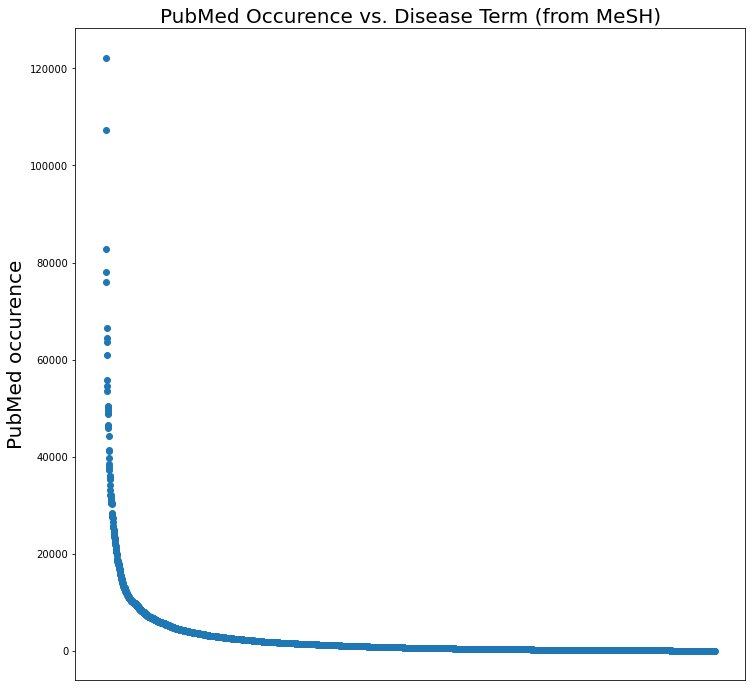

In [14]:
# PubMed occurence vs. disease name

fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(dfDisease["MeSH Disease Term"], dfDisease["PubMed occurrence"])

plt.title("PubMed Occurence vs. Disease Term (from MeSH)", fontsize=20)
plt.xlabel("Disease Term MeSH", fontsize=20)
plt.ylabel("PubMed occurence", fontsize=20)
ax.axes.xaxis.set_visible(False)
#plt.savefig("diseasePopularity.png", format="png")

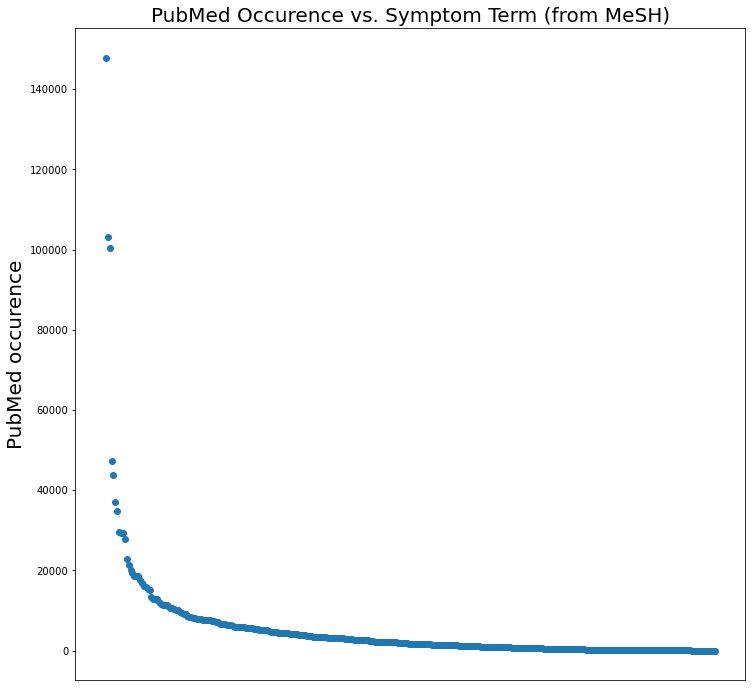

In [15]:
# PubMed occurence vs. symptom name

fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(dfSymptom["MeSH Symptom Term"], dfSymptom["PubMed occurrence"])
plt.title("PubMed Occurence vs. Symptom Term (from MeSH)", fontsize=20)
plt.xlabel("Symptom Term MeSH", fontsize=20)
plt.ylabel("PubMed occurence", fontsize=20)
ax.axes.xaxis.set_visible(False)
#plt.savefig("symptomPopularity.png", format="png")

# Bipartite Network

In [16]:
# Isolate Symptom and Disease term
dfHSDN = dfHSDN[dfHSDN["PubMed occurrence"] >= 150] # Popularity filter, set to 150 for testing
dfHSDN = dfHSDN[dfHSDN["MeSH Symptom Term"] != dfHSDN["MeSH Disease Term"]]
dfHSDNEdges = dfHSDN.reindex(columns = ["MeSH Symptom Term","MeSH Disease Term"])
dfHSDNEdges

,MeSH Symptom Term,MeSH Disease Term
668,Fever,Bacterial Infections
669,Fever,Bacteremia
816,Fever,Staphylococcal Infections
837,Fever,Infection
869,Fever,Sepsis
...,...,...
147273,"Urinary Incontinence, Stress",Postoperative Complications
147461,Virilism,Ovarian Neoplasms
147530,Virilism,"Adrenal Hyperplasia, Congenital"
147641,Hirsutism,Polycystic Ovary Syndrome


In [17]:
uniqueSymptomCount = dfHSDNEdges['MeSH Symptom Term'].unique()
uniqueDiseaseCount = dfHSDNEdges['MeSH Disease Term'].unique()

# Remove the rows that are in comm
dfHSDNEdges = dfHSDNEdges[~dfHSDNEdges['MeSH Symptom Term'].isin(comm)]

# Delete duplicate rows
dfHSDNEdges_ = dfHSDNEdges.drop_duplicates(subset=["MeSH Symptom Term","MeSH Disease Term"], keep=False)
dfHSDNEdges_

69


,MeSH Symptom Term,MeSH Disease Term
668,Fever,Bacterial Infections
669,Fever,Bacteremia
816,Fever,Staphylococcal Infections
837,Fever,Infection
869,Fever,Sepsis
...,...,...
147273,"Urinary Incontinence, Stress",Postoperative Complications
147461,Virilism,Ovarian Neoplasms
147530,Virilism,"Adrenal Hyperplasia, Congenital"
147641,Hirsutism,Polycystic Ovary Syndrome


In [18]:
# Get unique symptoms

dfUniqueSymptoms = dfHSDNEdges['MeSH Symptom Term'].unique()
len(dfUniqueSymptoms)

102

In [19]:
# Get unique diseases

dfUniqueDiseases = dfHSDNEdges['MeSH Disease Term'].unique()
len(dfUniqueDiseases)

262

In [20]:
# Join each disease to each symptom it is associated with in a tuple

listSymptomDiseaseJoin = list(dfHSDNEdges.to_records(index = False))
print(listSymptomDiseaseJoin)

[('Fever', 'Bacterial Infections'), ('Fever', 'Bacteremia'), ('Fever', 'Staphylococcal Infections'), ('Fever', 'Infection'), ('Fever', 'Sepsis'), ('Fever', 'Urinary Tract Infections'), ('Fever', 'Common Cold'), ('Fever', 'HIV Infections'), ('Fever', 'Malaria'), ('Fever', 'Malaria, Falciparum'), ('Fever', 'Leukemia'), ('Fever', 'Pneumonia'), ('Fever', 'Seizures'), ('Fever', 'Pain'), ('Fever', 'Agranulocytosis'), ('Fever', 'Neutropenia'), ('Fever', 'Skin Diseases'), ('Fever', 'Drug Hypersensitivity'), ('Fever', 'Inflammation'), ('Fever', 'Postoperative Complications'), ('Fever of Unknown Origin', 'Neutropenia'), ('Hypothermia', 'Heart Arrest'), ('Body Weight', 'HIV Infections'), ('Body Weight', 'Polycystic Ovary Syndrome'), ('Body Weight', 'Adenocarcinoma'), ('Body Weight', 'Breast Neoplasms'), ('Body Weight', 'Colonic Neoplasms'), ('Body Weight', 'Liver Neoplasms'), ('Body Weight', 'Liver Neoplasms, Experimental'), ('Body Weight', 'Pancreatic Neoplasms'), ('Body Weight', 'Mammary Neopla

In [21]:
# Create bipartite network with symptoms in one set, diseases in other set, join with edge list

GHSDNBipartite = nx.Graph()
GHSDNBipartite.add_nodes_from(dfUniqueSymptoms, bipartite = 0)
GHSDNBipartite.add_nodes_from(dfUniqueDiseases, bipartite = 1)
GHSDNBipartite.add_edges_from(listSymptomDiseaseJoin)

In [22]:
# Taking the largest connected component
components = sorted(nx.connected_components(GHSDNBipartite), key=len, reverse=True)
largestComponent = components[0]
GHSDNBipartiteII = GHSDNBipartite.subgraph(largestComponent)

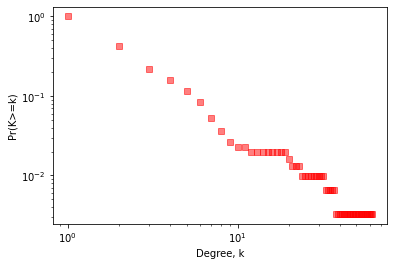

number of nodes, n  = 364
number of edges, m  = 433
diameter = 15
mean geodesic distance, <ell> =  4.80
clustering coefficient, C     =  0.00
number of components,   h     =  1
mean degree, k_mean = 2.379120879120879
max degree, k_max = 62
max degree, k_std =  4.96
0.008443158684238722


In [23]:
n = GHSDNBipartite.number_of_nodes()
m = GHSDNBipartite.number_of_edges()

# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(GHSDNBipartiteII)
ellmean = compute_MGD(GHSDNBipartiteII)
C = nx.transitivity(GHSDNBipartiteII) 
h = nx.number_connected_components(GHSDNBipartiteII)
degrees = [i[1] for i in GHSDNBipartiteII.degree()]
kmean = (2*m) / n
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?
print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'mean degree, k_mean = {kmean}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)

print(nx.density(GHSDNBipartiteII))

In [24]:
nx.is_connected(GHSDNBipartiteII)
print(nx.number_connected_components(GHSDNBipartiteII))

print([len(c) for c in sorted(nx.connected_components(GHSDNBipartiteII), key=len, reverse=True)])

1
[306]


In [25]:
# for component in list(nx.connected_components(GHSDNBipartiteII)):
#     if len(component) < 3:
#         for node in component:
#             GHSDNBipartiteII.remove_node(node)

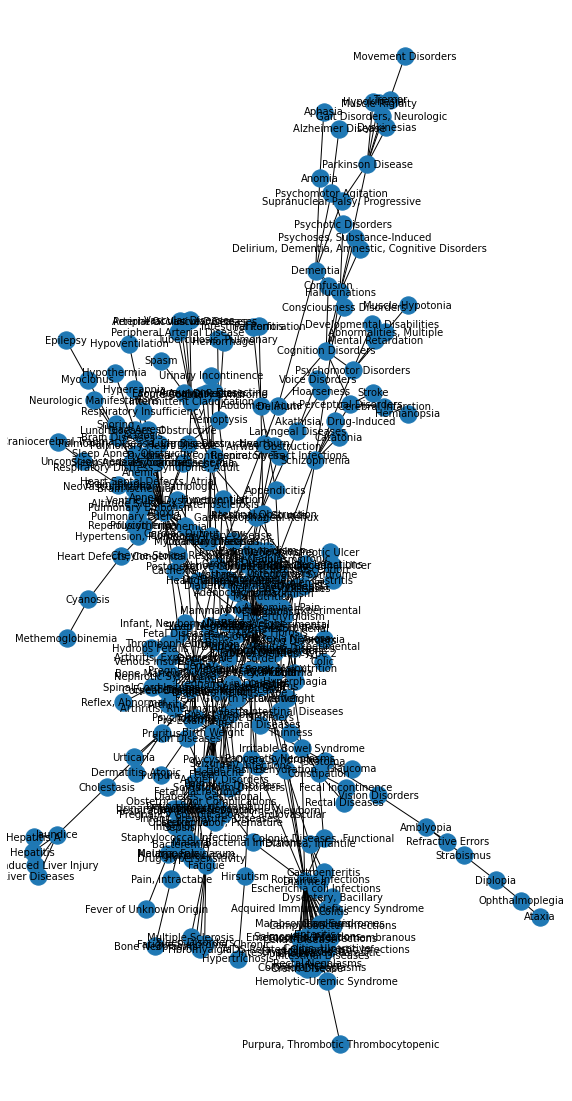

In [26]:
fig = plt.figure(figsize = (10, 20))
ax = fig.add_subplot(111)
ax.axis('off')

# Bipartite network visualization: https://stackoverflow.com/questions/27084004/bipartite-graph-in-networkx
symptomNodes, diseaseNodes = bipartite.sets(GHSDNBipartiteII)
partition = dict()
partition.update((n, (1, i)) for i, n in enumerate(symptomNodes)) # put nodes from N1
partition.update((n, (2, i)) for i, n in enumerate(diseaseNodes)) # put nodes from N2
nx.draw(GHSDNBipartiteII, with_labels = True, font_size=10)

# Uncomment for bipartite representation
#nx.draw(GHSDNBipartiteII, pos = partition, with_labels = True, font_size=10)
#plt.show()
plt.savefig("bipartiteGraphSymptomDiseaseBipartite.png", format="png")

# Visualize Symptom/Disease Subgraphs

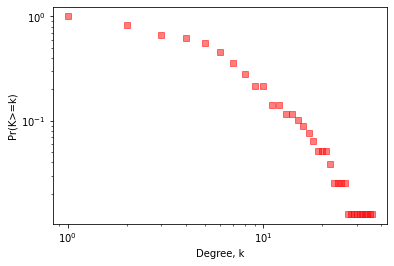

number of nodes, n  = 78
number of edges, m  = 252
diameter = 7
mean geodesic distance, <ell> =  2.67
clustering coefficient, C     =  0.40
number of components,   h     =  1
mean degree, k_mean = 6.461538461538462
max degree, k_max = 36
max degree, k_std =  6.28
0.08391608391608392


In [27]:
symptomSubgraph = bipartite.projected_graph(GHSDNBipartiteII, symptomNodes, multigraph=False)

n = symptomSubgraph.number_of_nodes()
m = symptomSubgraph.number_of_edges()

# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(symptomSubgraph)
ellmean = compute_MGD(symptomSubgraph)
C = nx.transitivity(symptomSubgraph) 
h = nx.number_connected_components(symptomSubgraph)
degrees = [i[1] for i in symptomSubgraph.degree()]
kmean = (2*m) / n
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?
print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'mean degree, k_mean = {kmean}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)

print(nx.density(symptomSubgraph))

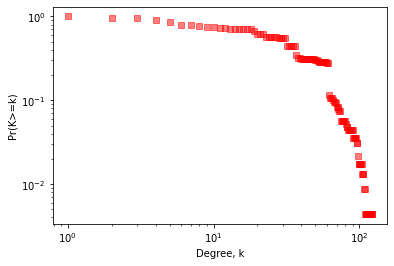

number of nodes, n  = 228
number of edges, m  = 3877
diameter = 7
mean geodesic distance, <ell> =  2.29
clustering coefficient, C     =  0.79
number of components,   h     =  1
mean degree, k_mean = 34.00877192982456
max degree, k_max = 123
max degree, k_std = 26.68
0.14981837854548266


In [28]:
diseaseSubgraph = bipartite.projected_graph(GHSDNBipartiteII, diseaseNodes, multigraph=False)

n = diseaseSubgraph.number_of_nodes()
m = diseaseSubgraph.number_of_edges()

# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(diseaseSubgraph)
ellmean = compute_MGD(diseaseSubgraph)
C = nx.transitivity(diseaseSubgraph) 
h = nx.number_connected_components(diseaseSubgraph)
degrees = [i[1] for i in diseaseSubgraph.degree()]
kmean = (2*m) / n
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?
print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'mean degree, k_mean = {kmean}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)

print(nx.density(diseaseSubgraph))

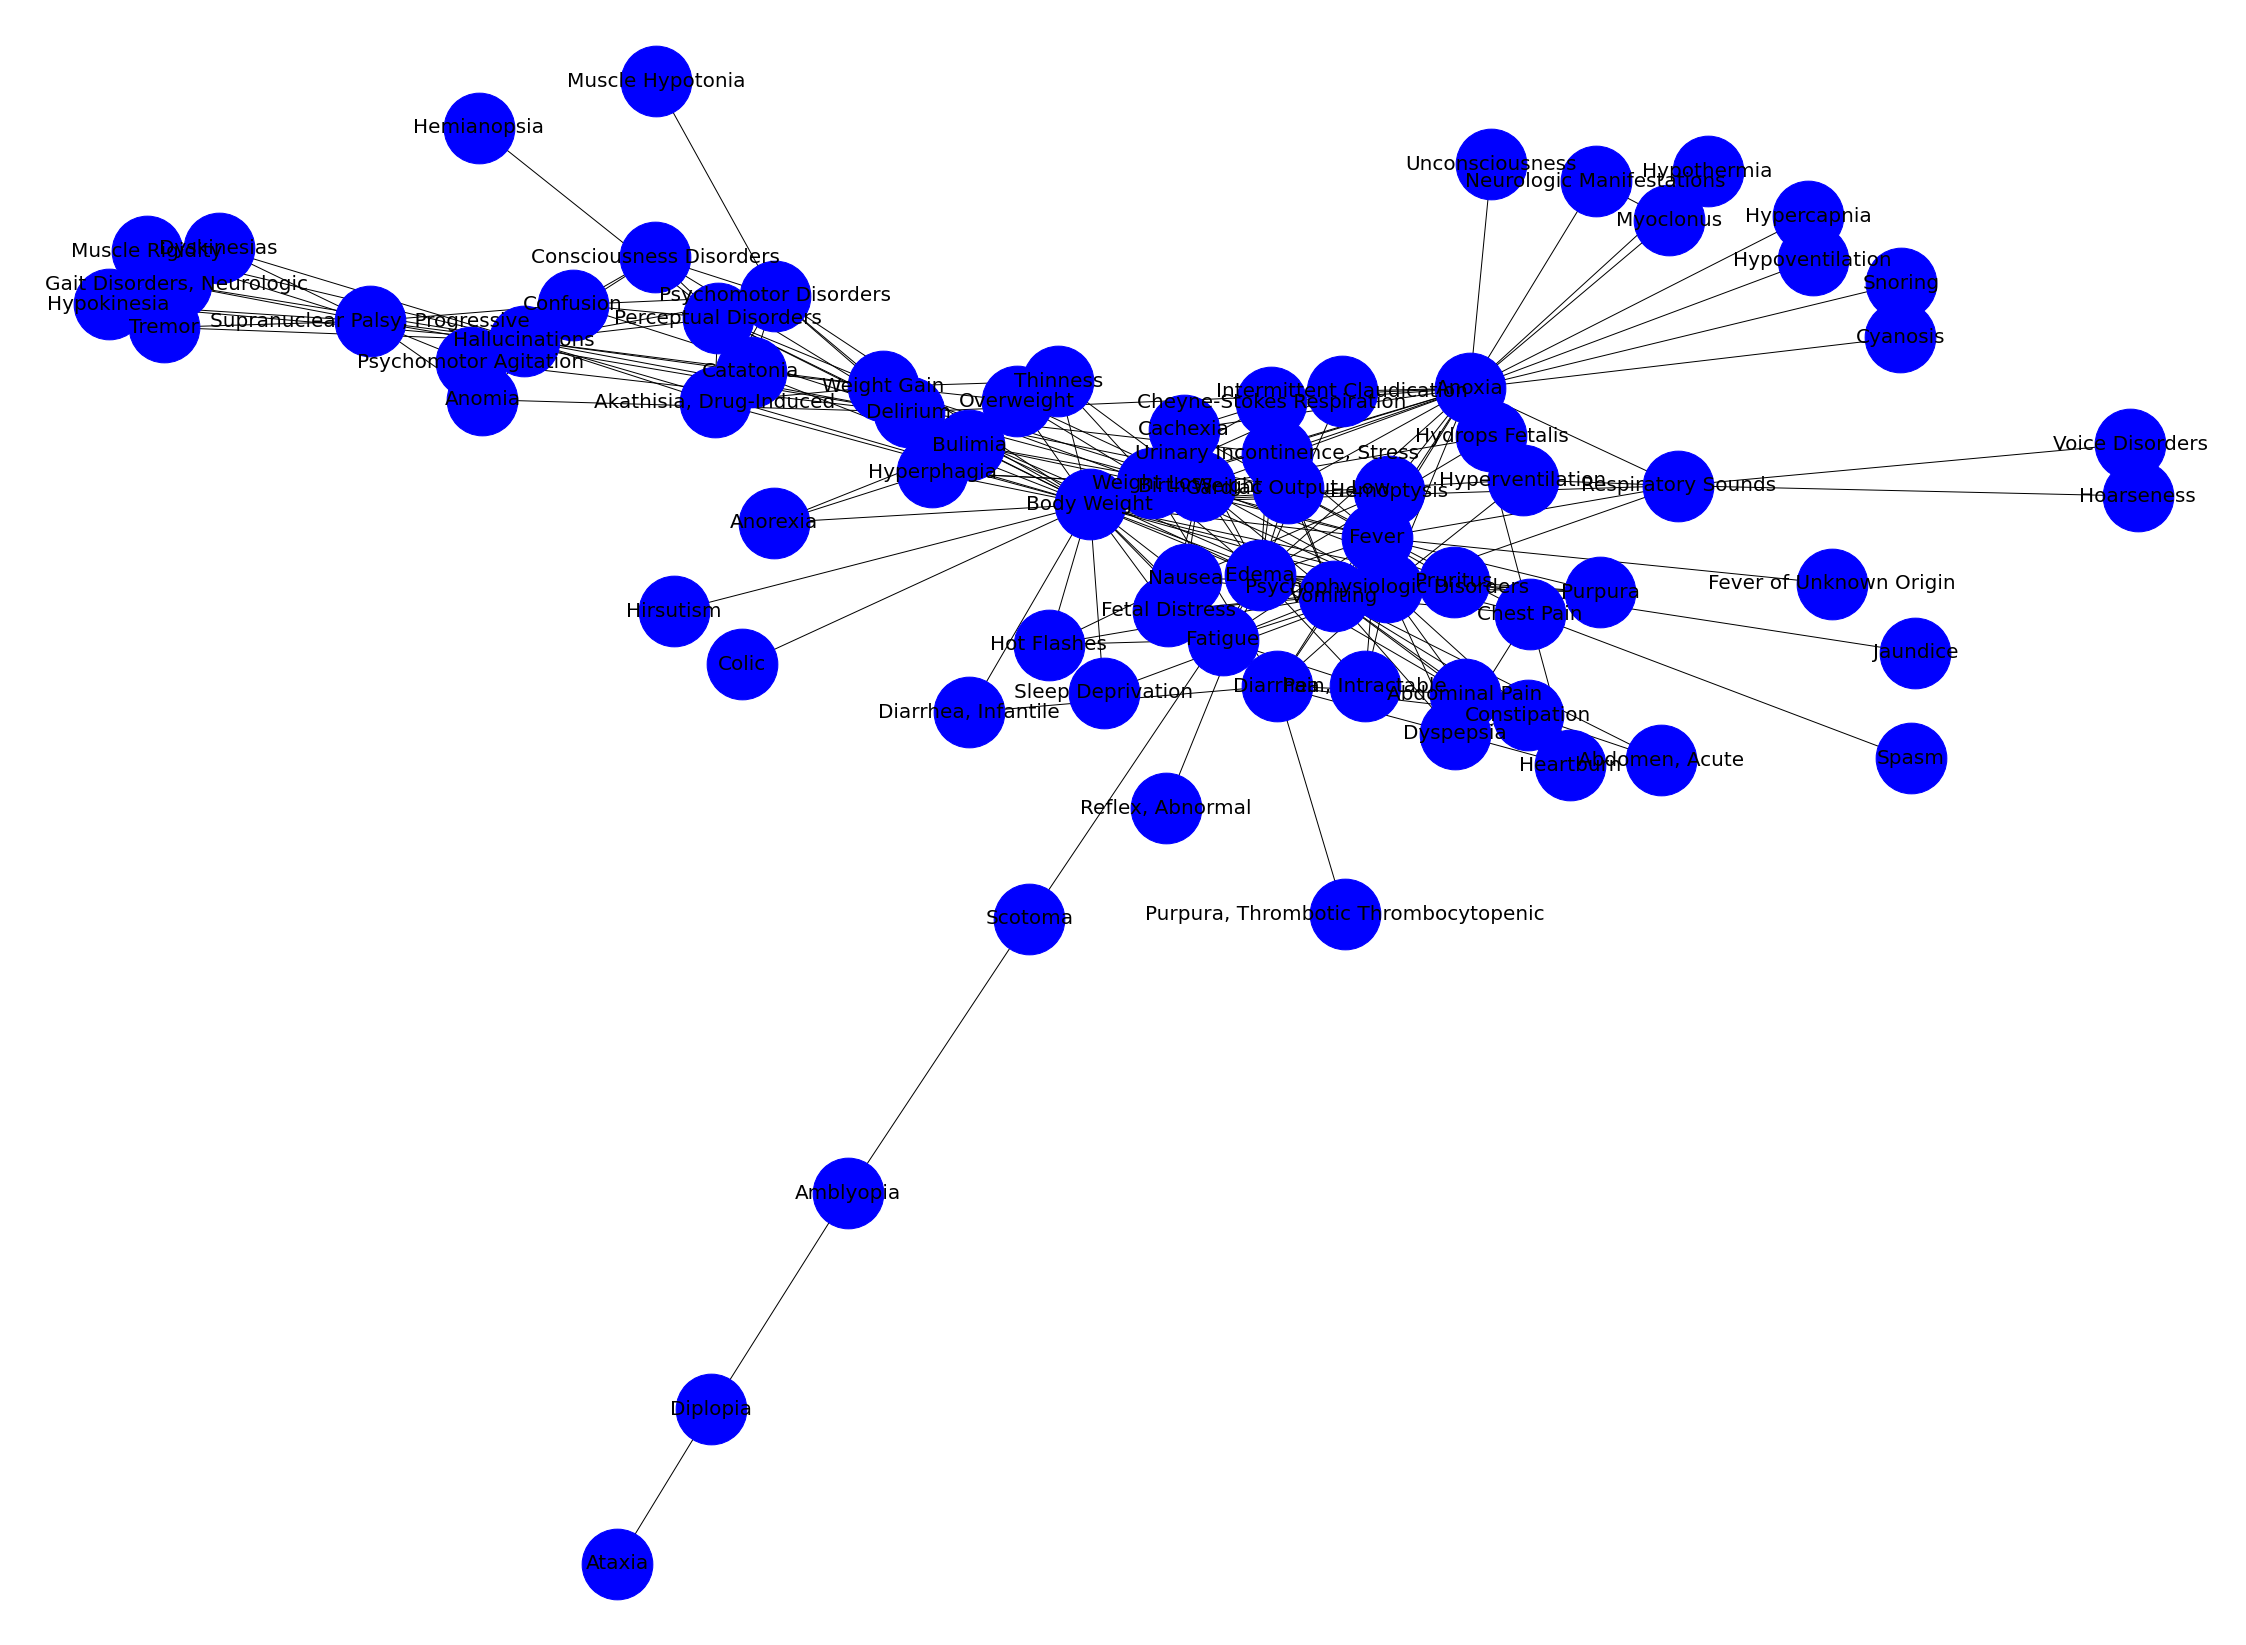

In [29]:
symptom_spring_pos = nx.spring_layout(symptomSubgraph)
fig, ax = plt.subplots(figsize = (40, 30))

node_size_default = 40

#n = nx.draw_networkx(symptomSubgraph, symptom_spring_pos, ax = ax, node_size = node_size_default, with_labels = True)

nx.draw_spring(symptomSubgraph, with_labels = 'True', node_size = 5000, font_color = 'black', node_color = 'blue', font_size=20)
plt.savefig("symptomSubgraph.svg", format="svg")

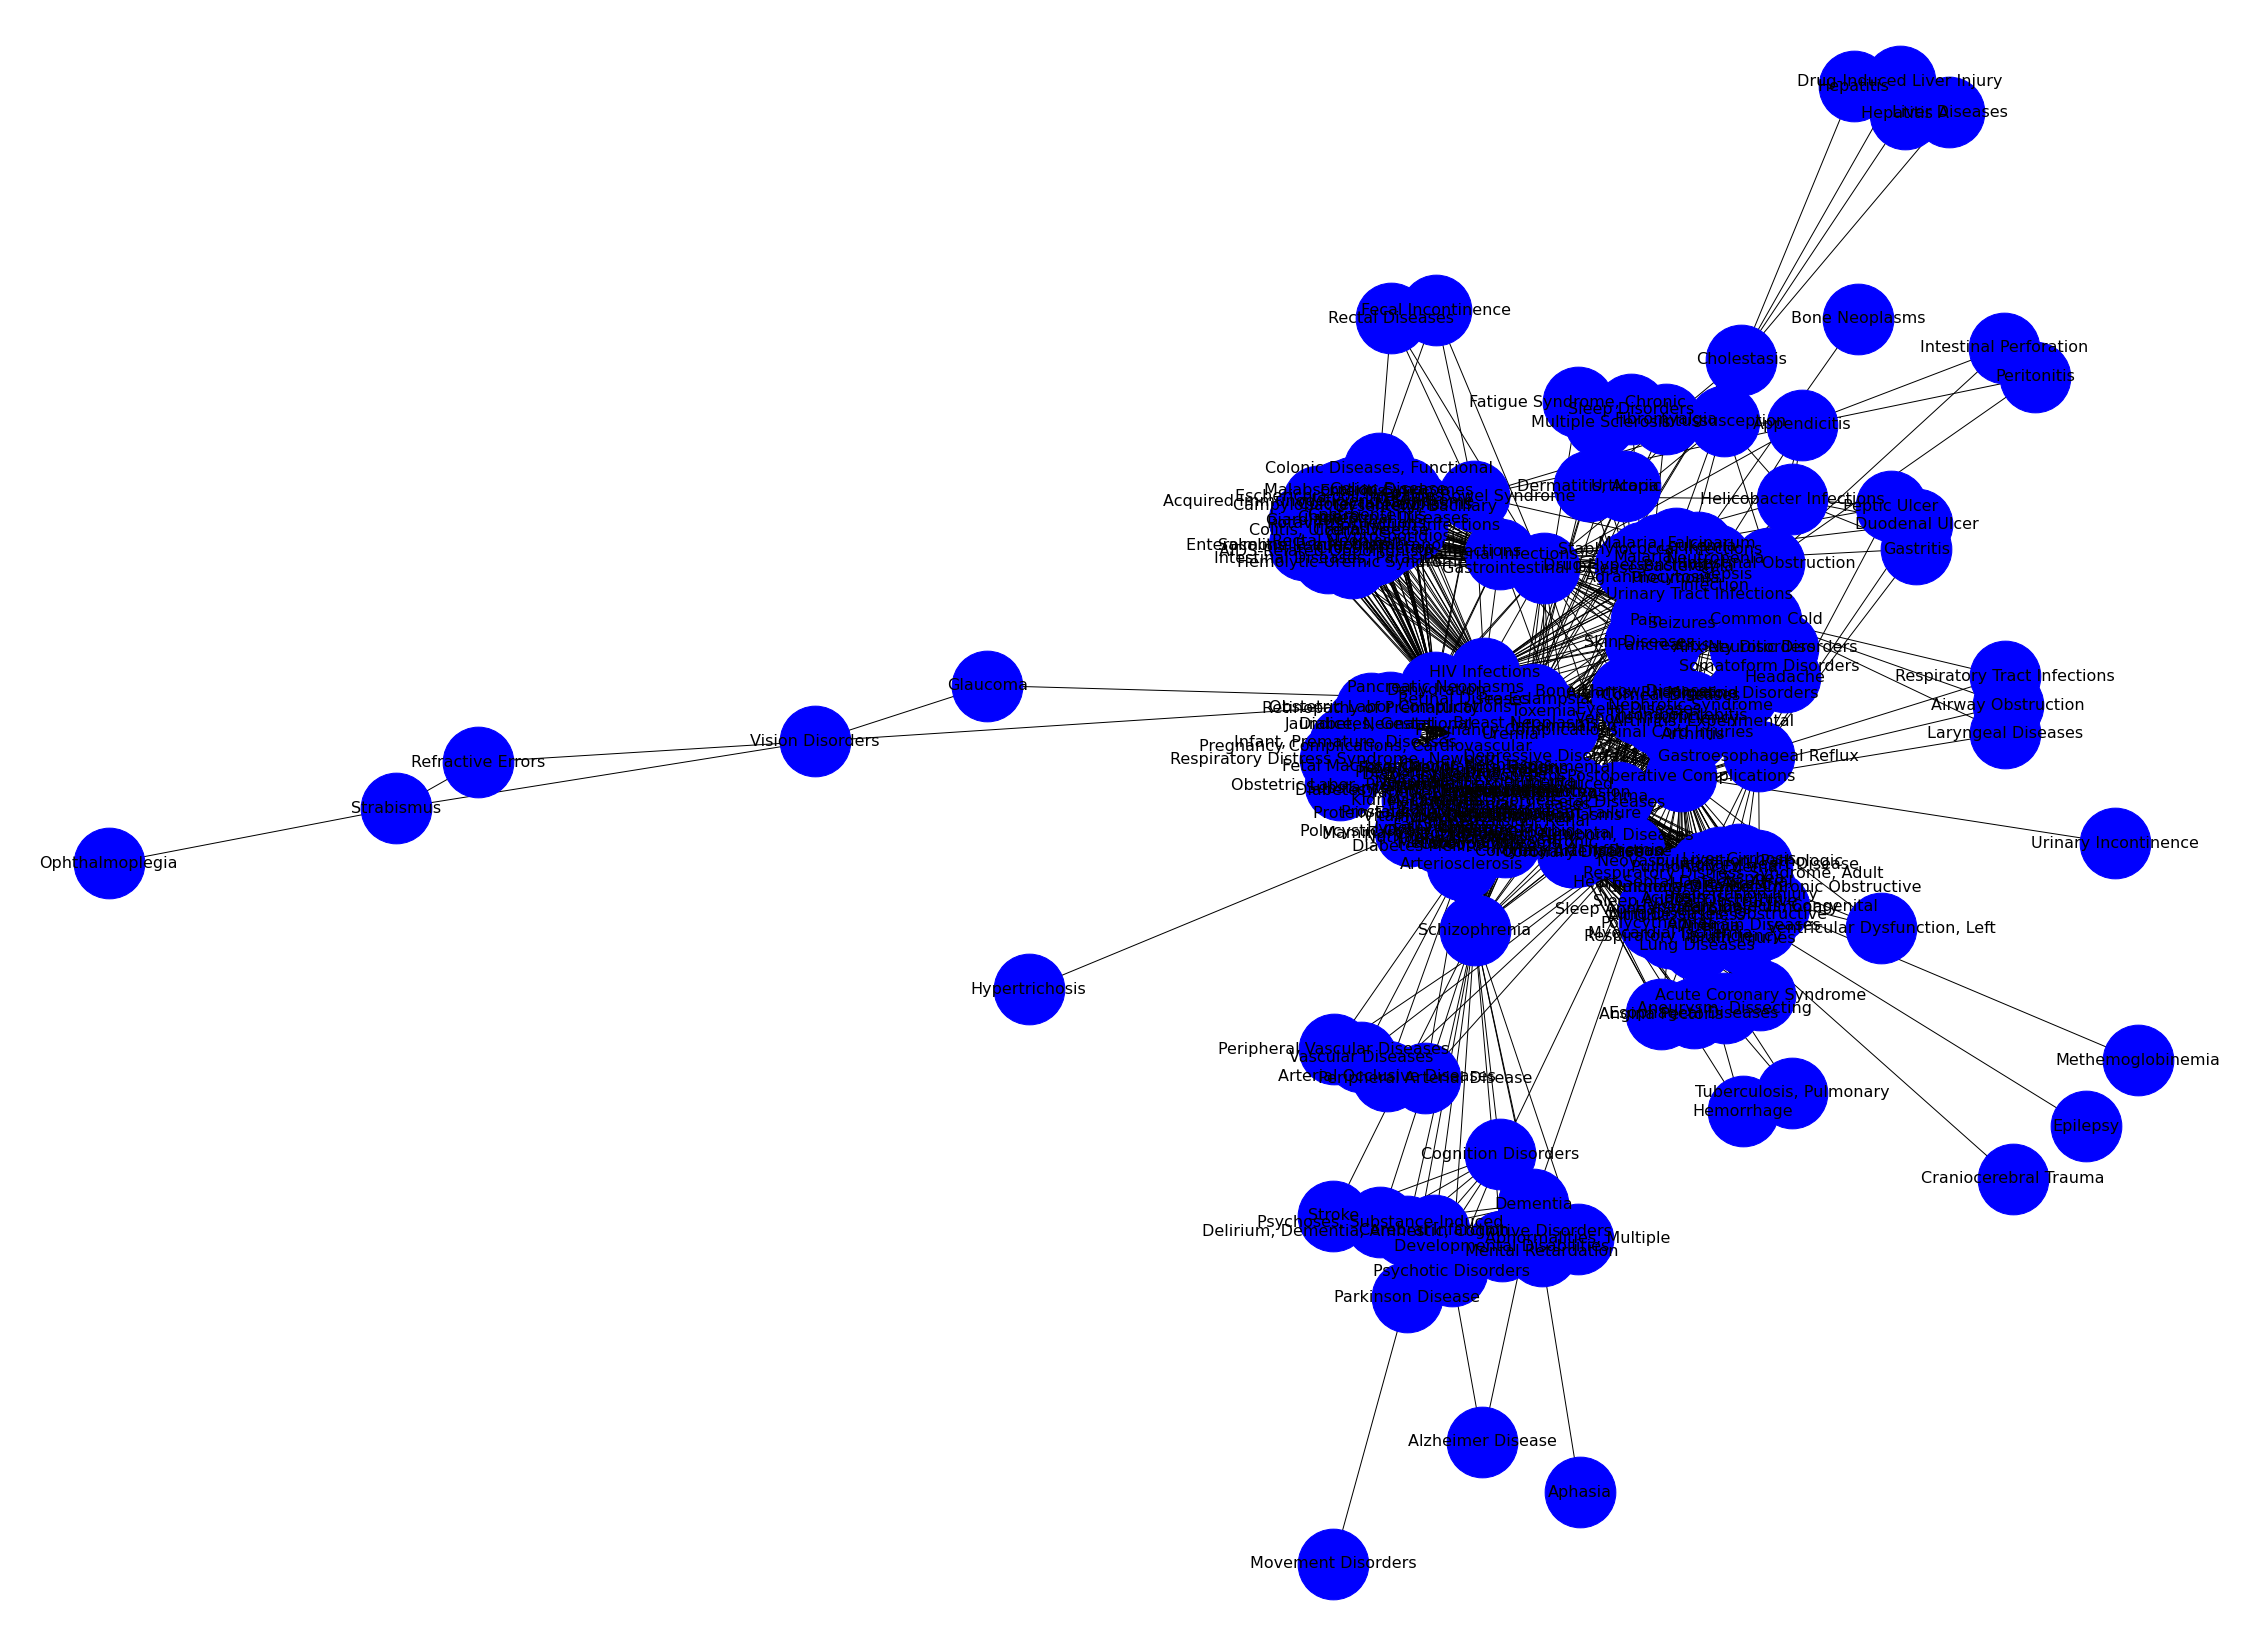

In [30]:
disease_spring_pos = nx.spring_layout(diseaseSubgraph)
fig, ax = plt.subplots(figsize = (40, 30))

node_size_default = 40

#n = nx.draw_networkx(diseaseSubgraph, disease_spring_pos, ax = ax, node_size = node_size_default, with_labels = True)
nx.draw_spring(diseaseSubgraph, with_labels = 'True', node_size = 5000, font_color = 'black', node_color = 'blue', font_size=16)
plt.savefig("diseaseSubgraph.svg", format="svg")

# Symptom Degree Analysis

In [31]:
symptomNodes = symptomSubgraph.nodes()
degreeSymptom = [i[1] for i in symptomSubgraph.degree()]

symptomNodesOrdered = [j for i, j in sorted(zip(degreeSymptom, symptomNodes), reverse=True)]
degreeSymptomSorted = sorted(degreeSymptom, reverse = True)

print("Top 10 sorted symtom nodes: ", symptomNodesOrdered[:10])
print("")
print("Top 10 sorted symptom degrees: ", degreeSymptomSorted[:10])
print("")
print("Bottom 10 sorted symtom nodes: ", symptomNodesOrdered[-10:])
print("")
print("Bottom 10 sorted symptom degrees: ", degreeSymptomSorted[-10:])

Top 10 sorted symtom nodes:  ['Body Weight', 'Anoxia', 'Vomiting', 'Edema', 'Psychophysiologic Disorders', 'Hallucinations', 'Fever', 'Birth Weight', 'Delirium', 'Weight Loss']

Top 10 sorted symptom degrees:  [36, 26, 22, 21, 18, 17, 16, 15, 14, 12]

Bottom 10 sorted symtom nodes:  ['Purpura, Thrombotic Thrombocytopenic', 'Muscle Hypotonia', 'Jaundice', 'Hypothermia', 'Hirsutism', 'Hemianopsia', 'Fever of Unknown Origin', 'Cyanosis', 'Colic', 'Ataxia']

Bottom 10 sorted symptom degrees:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


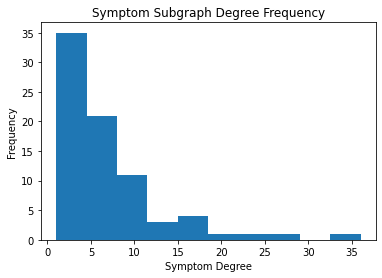

In [32]:
plt.hist(degreeSymptom)
plt.title("Symptom Subgraph Degree Frequency")
plt.xlabel("Symptom Degree")
plt.ylabel("Frequency")
plt.savefig("symptomDegree.svg", format="svg")

# Disease Degree Analysis

In [33]:
diseaseNodes = diseaseSubgraph.nodes()
degreeDisease = [i[1] for i in diseaseSubgraph.degree()]

diseaseNodesOrdered = [j for i, j in sorted(zip(degreeDisease, diseaseNodes), reverse=True)]
degreeDiseaseSorted = sorted(degreeDisease, reverse = True)

print("Top 10 sorted symtom nodes: ", diseaseNodesOrdered[:10])
print("")
print("Top 10 sorted symptom degrees: ", degreeDiseaseSorted[:10])
print("")
print("Bottom 10 sorted symtom nodes: ", diseaseNodesOrdered[-10:])
print("")
print("Bottom 10 sorted symptom degrees: ", degreeDiseaseSorted[-10:])

Top 10 sorted symtom nodes:  ['Hypertension', 'Heart Failure', 'HIV Infections', 'Asthma', 'Myocardial Infarction', 'Coronary Disease', 'Coronary Artery Disease', 'Inflammation', 'Pancreatic Neoplasms', 'Dehydration']

Top 10 sorted symptom degrees:  [123, 109, 107, 104, 98, 97, 97, 95, 90, 90]

Bottom 10 sorted symtom nodes:  ['Alzheimer Disease', 'Urinary Incontinence', 'Ophthalmoplegia', 'Movement Disorders', 'Methemoglobinemia', 'Hypertrichosis', 'Epilepsy', 'Craniocerebral Trauma', 'Bone Neoplasms', 'Aphasia']

Bottom 10 sorted symptom degrees:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


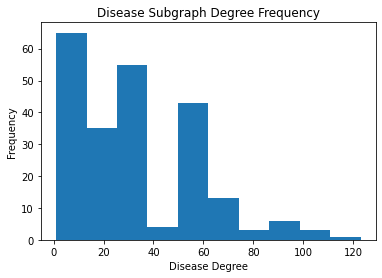

In [34]:
plt.hist(degreeDisease)
plt.title("Disease Subgraph Degree Frequency")
plt.xlabel("Disease Degree")
plt.ylabel("Frequency")
plt.savefig("diseaseDegree.svg", format="svg")

# Community Detection (Louvain Algorithms)

Symptom communities:  5


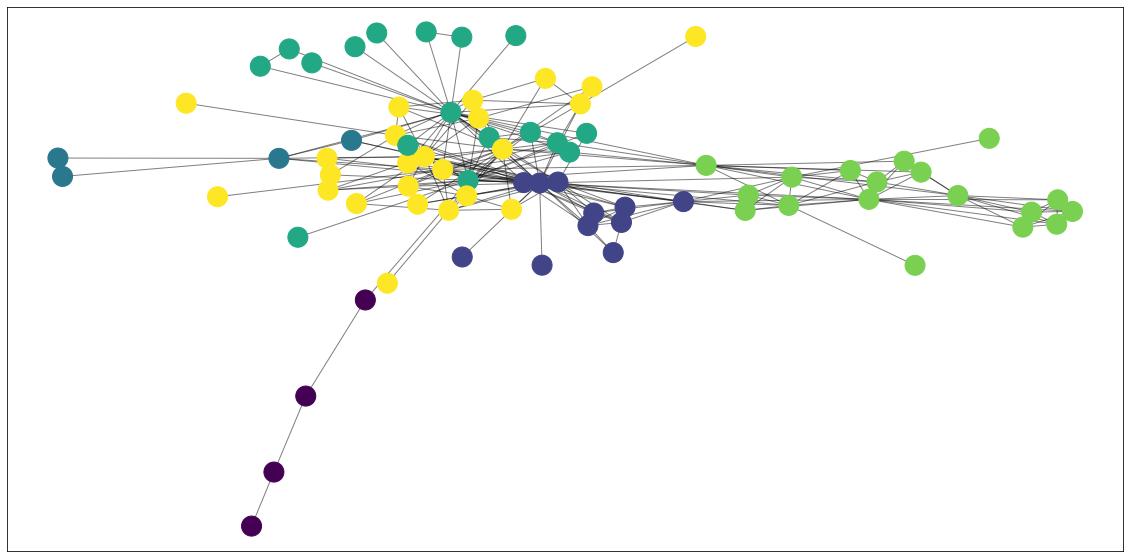

In [35]:
# Symptom subgraph
# https://medium.com/walmartglobaltech/demystifying-louvains-algorithm-and-its-implementation-in-gpu-9a07cdd3b010
# https://readthedocs.org/projects/louvain-igraph/downloads/pdf/latest/
fig, ax = plt.subplots(figsize = (20, 10))

louvainSymptomClusteringPartition = community_louvain.best_partition(symptomSubgraph)
communitiesSymptoms = [louvainSymptomClusteringPartition.get(node) for node in symptomSubgraph.nodes()]
print("Symptom communities: ", max(communitiesSymptoms))

symptomSpringLayout = nx.spring_layout(symptomSubgraph)
cmap = cm.get_cmap('viridis', max(louvainSymptomClusteringPartition.values()) + 1)

nx.draw_networkx_nodes(symptomSubgraph, symptomSpringLayout, louvainSymptomClusteringPartition.keys(), node_size=400, cmap=cmap, node_color=list(louvainSymptomClusteringPartition.values()))

nx.draw_networkx_edges(symptomSubgraph, symptomSpringLayout, alpha=0.5)
plt.savefig("symptomSubgraphLouvain.svg", format="svg")

Disease communities:  6


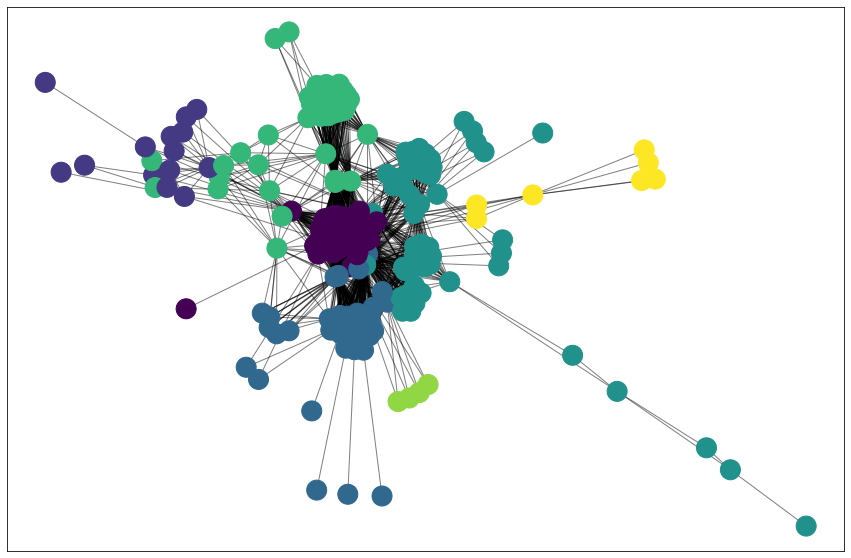

In [36]:
# Disease subgraph
# https://readthedocs.org/projects/louvain-igraph/downloads/pdf/latest/
fig, ax = plt.subplots(figsize = (15, 10))

louvainDiseaseClusteringPartition = community_louvain.best_partition(diseaseSubgraph)
communitiesDisease = [louvainDiseaseClusteringPartition.get(node) for node in diseaseSubgraph.nodes()]
print("Disease communities: ", max(communitiesDisease))

diseaseSpringLayout = nx.spring_layout(diseaseSubgraph)
cmap = cm.get_cmap('viridis', max(louvainDiseaseClusteringPartition.values()) + 1)

nx.draw_networkx_nodes(diseaseSubgraph, diseaseSpringLayout, louvainDiseaseClusteringPartition.keys(), node_size=400, cmap=cmap, node_color=list(louvainDiseaseClusteringPartition.values()))

nx.draw_networkx_edges(diseaseSubgraph, diseaseSpringLayout, alpha=0.5)
plt.savefig("diseaseSubgraphLouvain.svg", format="svg")

# Community Insights

In [37]:
# Symptom network (Idea is to take Louvain partition, and create a list of symptoms per each community)
symptomGroupDict = {}
for i, v in louvainSymptomClusteringPartition.items():
    if v not in symptomGroupDict.keys():
        symptomGroupDict[v] = [i]  
    else:
        symptomGroupDict[v] = symptomGroupDict[v] + [i]
print(symptomGroupDict)

{4: ['Consciousness Disorders', 'Muscle Hypotonia', 'Hallucinations', 'Delirium', 'Catatonia', 'Hemianopsia', 'Dyskinesias', 'Anomia', 'Hypokinesia', 'Gait Disorders, Neurologic', 'Perceptual Disorders', 'Confusion', 'Muscle Rigidity', 'Akathisia, Drug-Induced', 'Psychomotor Agitation', 'Psychomotor Disorders', 'Tremor', 'Supranuclear Palsy, Progressive'], 3: ['Snoring', 'Anoxia', 'Urinary Incontinence, Stress', 'Cyanosis', 'Cardiac Output, Low', 'Reflex, Abnormal', 'Cachexia', 'Hypoventilation', 'Hypercapnia', 'Cheyne-Stokes Respiration', 'Myoclonus', 'Neurologic Manifestations', 'Unconsciousness', 'Hydrops Fetalis', 'Edema', 'Hypothermia', 'Intermittent Claudication'], 5: ['Chest Pain', 'Fever of Unknown Origin', 'Abdomen, Acute', 'Fetal Distress', 'Diarrhea', 'Abdominal Pain', 'Jaundice', 'Spasm', 'Hot Flashes', 'Hemoptysis', 'Pruritus', 'Constipation', 'Sleep Deprivation', 'Pain, Intractable', 'Psychophysiologic Disorders', 'Fatigue', 'Diarrhea, Infantile', 'Nausea', 'Dyspepsia', '

In [38]:
# Disease network (Idea is to take Louvain partition, and create a list of diseases per each community)
diseaseGroupDict = {}
for i, v in louvainDiseaseClusteringPartition.items():
    if v not in diseaseGroupDict.keys():
        diseaseGroupDict[v] = [i] 
    else: 
        diseaseGroupDict[v] = diseaseGroupDict[v] + [i]
print(diseaseGroupDict)

{0: ['Diabetic Nephropathies', 'Liver Neoplasms, Experimental', 'Liver Neoplasms', 'Anorexia Nervosa', 'Pregnancy Complications', 'Diabetes Mellitus', 'Hypercholesterolemia', 'Obesity, Morbid', 'Diabetes Mellitus, Experimental', 'Pregnancy in Diabetics', 'Schizophrenia', 'Protein Deficiency', 'Nutrition Disorders', 'Substance Withdrawal Syndrome', 'Prostatic Neoplasms', 'Hypertension, Renal', 'Fatty Liver', 'Hypothyroidism', 'Hyperlipidemias', 'Growth Disorders', 'Osteoporosis', 'Cardiomegaly', 'Fetal Growth Retardation', 'Mammary Neoplasms, Experimental', 'Kidney Diseases', 'Hyperglycemia', 'Starvation', 'Adenocarcinoma', 'Metabolic Syndrome X', 'Vitamin A Deficiency', 'Malnutrition', 'Kidney Failure, Chronic', 'Hyperinsulinism', 'Abnormalities, Drug-Induced', 'Alcoholism', 'Deficiency Diseases', 'Colonic Neoplasms', 'Depressive Disorder', 'Cystic Fibrosis', 'Diabetes Mellitus, Type 2', 'Lung Neoplasms', 'Hyperthyroidism', 'Protein-Energy Malnutrition', 'Uremia', 'Hypertrichosis', 'Ar



Community:  0


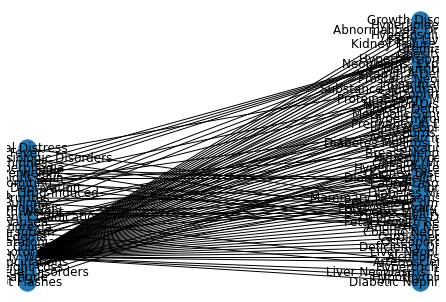

Body Weight :  53
Weight Loss :  6
Birth Weight :  5
Weight Gain :  4
Nausea :  4
Bulimia :  3
Vomiting :  3
Hyperphagia :  3
Pruritus :  2
Overweight :  2
Edema :  2
Hirsutism :  2
Hot Flashes :  1
Fatigue :  1
Akathisia, Drug-Induced :  1
Hemoptysis :  1
Perceptual Disorders :  1
Sleep Deprivation :  1
Hallucinations :  1
Psychomotor Disorders :  1
Colic :  1
Catatonia :  1
Thinness :  1
Anorexia :  1
Psychophysiologic Disorders :  1
Intermittent Claudication :  1
Fever :  1
Fetal Distress :  1


Community:  1


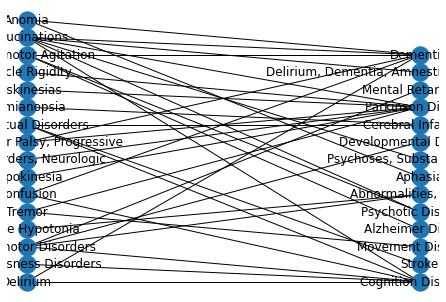

Hallucinations :  6
Psychomotor Disorders :  4
Perceptual Disorders :  3
Psychomotor Agitation :  3
Tremor :  2
Supranuclear Palsy, Progressive :  2
Delirium :  2
Confusion :  2
Anomia :  2
Consciousness Disorders :  1
Muscle Hypotonia :  1
Hypokinesia :  1
Gait Disorders, Neurologic :  1
Hemianopsia :  1
Dyskinesias :  1
Muscle Rigidity :  1


Community:  2


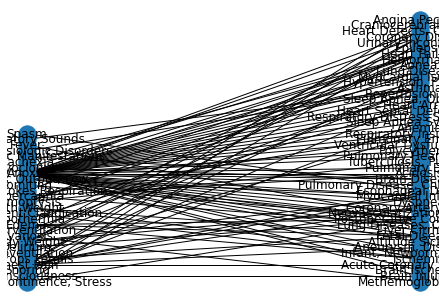

Anoxia :  36
Chest Pain :  8
Body Weight :  5
Cardiac Output, Low :  4
Edema :  4
Hypercapnia :  3
Hemoptysis :  3
Urinary Incontinence, Stress :  2
Unconsciousness :  2
Snoring :  2
Myoclonus :  2
Cyanosis :  2
Birth Weight :  2
Cheyne-Stokes Respiration :  1
Vomiting :  1
Hydrops Fetalis :  1
Cachexia :  1
Hypoventilation :  1
Delirium :  1
Hyperventilation :  1
Neurologic Manifestations :  1
Psychophysiologic Disorders :  1
Fever :  1
Hypothermia :  1
Intermittent Claudication :  1
Respiratory Sounds :  1
Spasm :  1


Community:  3


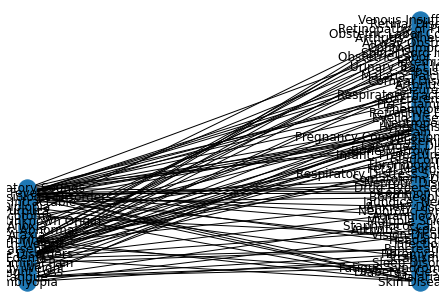

Edema :  17
Fever :  16
Birth Weight :  12
Psychophysiologic Disorders :  8
Fatigue :  5
Respiratory Sounds :  4
Amblyopia :  3
Scotoma :  3
Diplopia :  2
Pain, Intractable :  2
Pruritus :  1
Ataxia :  1
Reflex, Abnormal :  1
Anoxia :  1
Weight Loss :  1
Fever of Unknown Origin :  1
Purpura :  1
Body Weight :  1
Abdominal Pain :  1
Voice Disorders :  1
Hoarseness :  1


Community:  4


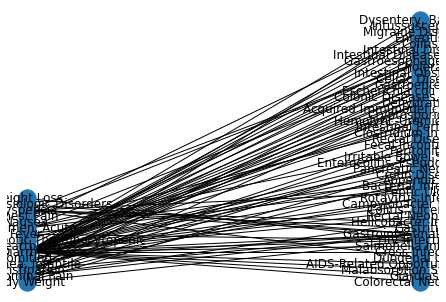

Diarrhea :  32
Abdominal Pain :  6
Dyspepsia :  6
Constipation :  5
Diarrhea, Infantile :  4
Vomiting :  4
Abdomen, Acute :  4
Body Weight :  3
Fever :  2
Heartburn :  1
Purpura, Thrombotic Thrombocytopenic :  1
Nausea :  1
Chest Pain :  1
Psychophysiologic Disorders :  1
Weight Loss :  1


Community:  5


<Figure size 432x288 with 0 Axes>

In [40]:
numDiseaseCommunitiesLouvain = max(communitiesDisease)

for i in range(numDiseaseCommunitiesLouvain):
    # Identify community
    print("\n")
    print("Community: ", i)
    communityList = diseaseGroupDict[i]
    
    diseaseEdges_ = dfHSDNEdges_[dfHSDNEdges_["MeSH Disease Term"].isin(communityList)] # Find edges of communities from Louvain
    
    topSymptoms = []
    bottomSymtoms = []
    
    if (len(diseaseEdges_['MeSH Symptom Term'].unique()) > 3): # Verify that there are enough edges in for community
        diseaseBipartiteSet = diseaseEdges_['MeSH Disease Term'].unique()
        symptomBipartiteSet = diseaseEdges_['MeSH Symptom Term'].unique()
        
        listSymptomDiseaseJoin_ = list(diseaseEdges_.to_records(index = False)) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_records.html
        
        # Construct community bipartite network
        bipartiteCommon = nx.Graph()
        bipartiteCommon.add_nodes_from(symptomBipartiteSet, bipartite = 0)
        bipartiteCommon.add_nodes_from(diseaseBipartiteSet, bipartite = 1)
        bipartiteCommon.add_edges_from(listSymptomDiseaseJoin_)
        
        # Take largest component (sanity check in case there are modules that are not connected)
        components = sorted(nx.connected_components(bipartiteCommon), key = len, reverse = True)
        largestComponent = components[0]
        bipartiteCommon = bipartiteCommon.subgraph(largestComponent)

        
        ## HAZARD: BROKEN CODE (Not anymore lol) ##
        # https://stackoverflow.com/questions/27084004/bipartite-graph-in-networkx
        node1Set, node2Set = bipartite.sets(bipartiteCommon)
        partitionCommunitySet = dict()
        partitionCommunitySet.update((n, (1, i)) for i, n in enumerate(node1Set)) 
        partitionCommunitySet.update((n, (2, i)) for i, n in enumerate(node2Set))
        
        nx.draw(bipartiteCommon, pos = partitionCommunitySet, with_labels = True)
        plt.show()
        plt.savefig("community-{}.svg".format(i), format="svg")
        plt.clf()
        
        # Extract degrees for disease nodes (Print top symptoms form each )
        degX, degY = bipartite.degrees(bipartiteCommon, node1Set)
        degY = dict(degY)
        symptomsSorted= dict(sorted(degY.items(), key = lambda item: item[1], reverse = True))

        # Print sorted symptoms
        for k, v in symptomsSorted.items():
            print(k, ": ", v)

# Regular DC-SBM On Disease/Symptom Subgraphs

### Helper Functions (From PS6)

In [41]:
def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####

    for e in list(G.edges()): # Go through list of edges
        node1 = e[0] # Get node 1 as e[0]
        node2 = e[1] # Get node 2 as e[1]
         
        wrs[z[node1]][z[node2]] += 1 # Increment wrs with 1 for stub going from node 1 (to node 2)
        wrs[z[node2]][z[node1]] += 1 # Increment wrs with 1 for stub going from node 2 (to node 1)
        
    kpr = np.sum(wrs, axis = 1) # Use np.sum to sum columns to get kpr
    ##### do not modify below here #####

    return wrs,kpr

In [42]:
def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####
    
    for i in range(n): # Loop through number of nodes
        z[i] = int(np.round(np.random.uniform(0, c - 1))) # Generate a uniform number between 0 and c - 1

    ##### do not modify below here #####

    return z

In [43]:
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

In [44]:
def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [45]:
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####

                z[i] = r # Change i's type to r
                wrs, kpr = tabulate_wk(G, z, c) # Calculate wrs, kpr for logL function
                
                logScore = dcsbm_LogL(wrs,kpr) # Calculate log-likelihood function value for wrs and kpr
                
                if (logScore > bestL): # Find if current logScore is better than bestL (max)
                    bestL = logScore # set the best log-likelihood found
                    bestMove = (i, r) # set the node i and new group r to achieve bestL
                
            z[i] = s # Change i back to current label s
                
                ##### do not modify below here #####    
                
    return bestL,bestMove

In [46]:
def run_OnePhase(G,z0,c):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(n), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        #print(f'step {j}') # for debugging

        ##### do not modify above here #####

        bestL, bestMove = makeAMove(G, zt, c, f) # Find the best move with G, zt, c, f
        LL.append(bestL) # Append log-likelihood to LL list
        
        f[bestMove[0]] = 1 # Freeze the node with the best move
        zt[bestMove[0]] = bestMove[1] # Change group of the best move node
        
        if (bestL > Lstar): # If the log likelihood from the move is greater than the current log-likelihood of zstar
            Lstar = bestL # Update Lstar
            zstar = copy.deepcopy(zt) # Recopy zstar
        
        if (zstar == z0): # If zstar (best partition) equals the initial partition
            halt = 1 # Halt the phase
        
        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

In [47]:
def fit_DCSBM(G,c,T): 
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        #print(f'phase[{pc}] z[0], logL = {Lt}')
        #drawGz(G,zt)

        ##### do not modify above here #####

        zstar, Lstar, LLOnePhase, hOnePhase = run_OnePhase(G, zt, c) # While we are not stopped, run one phase with G, zt, c
        
        zt = copy.deepcopy(zstar) # Make a deepcopy of the partition for the next iteration run potentially 
        halt = hOnePhase # Save the halt return from run_OnePhase
        
        for i in LLOnePhase: # Go through all of the log-likelihood values for the n + 1 partitions of this phase 
            LL.append(i) # Append to log likelihood list for entire algorithm
        
        pc = pc + 1 # Increment phase counter by 1
        
        if (pc == T): # If we are at the maximum phases allowed, then we should halt the algorithm
            halt = 1
        
        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [48]:
def fit_DCSBM_reps(G, c, T, reps):
    best_LL = [] # Use a list to track the best log likelihoods
    best_L = -np.inf # Variable to store the maxd log likelihood from repetition
    
    for rep in range(reps): # Loop through repetitions
        zstar_new, Lstar_new, LL_new, pc_new = fit_DCSBM(G, c, T) # Fit a DC-SBM model
        maxLLRun = max(LL_new) # Get the max log likelihood from the algorithm fit
        
        if (maxLLRun > best_L): # Reassign maximum log likelihood if needbe
            best_L = maxLLRun
            bestZStar = copy.deepcopy(zstar_new) # Make a copy of the group orderings
        
        best_LL.append(maxLLRun) # Append the new maximum to the log likelihood list
    
    return best_LL, bestZStar # Return the best log likelihood list and the best grouping

### Random Partition Symptom Subgraph

Symptom Subgraph Nodes:  78
Symptom Subgraph Partition:  {0: 3, 1: 1, 2: 2, 3: 2, 4: 1, 5: 4, 6: 1, 7: 2, 8: 1, 9: 2, 10: 1, 11: 1, 12: 0, 13: 2, 14: 0, 15: 3, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 4, 22: 1, 23: 2, 24: 0, 25: 0, 26: 4, 27: 2, 28: 3, 29: 1, 30: 1, 31: 2, 32: 3, 33: 3, 34: 2, 35: 4, 36: 2, 37: 1, 38: 3, 39: 2, 40: 2, 41: 0, 42: 0, 43: 2, 44: 2, 45: 3, 46: 0, 47: 3, 48: 3, 49: 1, 50: 2, 51: 2, 52: 0, 53: 0, 54: 1, 55: 0, 56: 2, 57: 0, 58: 2, 59: 4, 60: 3, 61: 0, 62: 2, 63: 0, 64: 4, 65: 1, 66: 1, 67: 3, 68: 0, 69: 4, 70: 1, 71: 1, 72: 1, 73: 3, 74: 2, 75: 4, 76: 0, 77: 3}
kappa_r symtpom = 
[109. 195.  87.  70.  43.]
w_rs symptom = 
[[34. 35. 13. 18.  9.]
 [35. 64. 43. 34. 19.]
 [13. 43. 14. 10.  7.]
 [18. 34. 10.  2.  6.]
 [ 9. 19.  7.  6.  2.]]


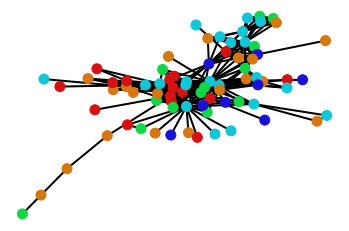

In [49]:
symptomSubgraphInts      = nx.convert_node_labels_to_integers(symptomSubgraph) # map node names to integers (0:n-1) [because indexing]

nSymptom = symptomSubgraphInts.order()
print("Symptom Subgraph Nodes: ", nSymptom)
cSymptom = 5 # From previous Louvain partition
zSymptom = random_z(nSymptom, cSymptom)
print("Symptom Subgraph Partition: ", zSymptom)
wrsSymptom,kprSymptom = tabulate_wk(symptomSubgraphInts, zSymptom, cSymptom)
print(f'kappa_r symtpom = ')
print(kprSymptom)
print(f'w_rs symptom = ')
print(wrsSymptom)

drawGz(symptomSubgraphInts,zSymptom)

### Random Partition Disease Subgraph

Symptom Subgraph Nodes:  228
Symptom Subgraph Partition:  {0: 2, 1: 3, 2: 2, 3: 4, 4: 2, 5: 2, 6: 4, 7: 2, 8: 3, 9: 3, 10: 2, 11: 1, 12: 4, 13: 2, 14: 3, 15: 1, 16: 2, 17: 1, 18: 0, 19: 3, 20: 2, 21: 1, 22: 4, 23: 1, 24: 4, 25: 0, 26: 1, 27: 0, 28: 1, 29: 1, 30: 3, 31: 2, 32: 3, 33: 4, 34: 1, 35: 3, 36: 0, 37: 3, 38: 1, 39: 1, 40: 0, 41: 0, 42: 0, 43: 4, 44: 1, 45: 1, 46: 1, 47: 3, 48: 3, 49: 2, 50: 1, 51: 2, 52: 3, 53: 0, 54: 1, 55: 3, 56: 2, 57: 2, 58: 2, 59: 1, 60: 1, 61: 2, 62: 0, 63: 3, 64: 4, 65: 3, 66: 3, 67: 3, 68: 1, 69: 1, 70: 2, 71: 3, 72: 3, 73: 4, 74: 2, 75: 4, 76: 2, 77: 1, 78: 3, 79: 2, 80: 3, 81: 2, 82: 1, 83: 1, 84: 2, 85: 3, 86: 3, 87: 4, 88: 1, 89: 2, 90: 3, 91: 3, 92: 1, 93: 3, 94: 2, 95: 3, 96: 1, 97: 2, 98: 3, 99: 0, 100: 4, 101: 1, 102: 2, 103: 2, 104: 2, 105: 3, 106: 0, 107: 1, 108: 1, 109: 1, 110: 4, 111: 3, 112: 0, 113: 4, 114: 0, 115: 0, 116: 1, 117: 3, 118: 4, 119: 4, 120: 3, 121: 3, 122: 1, 123: 0, 124: 3, 125: 2, 126: 2, 127: 2, 128: 0, 129: 2, 130: 0, 131

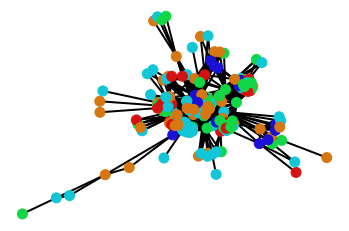

In [50]:
diseaseSubgraphInts      = nx.convert_node_labels_to_integers(diseaseSubgraph) # map node names to integers (0:n-1) [because indexing]

nDisease = diseaseSubgraphInts.order()
print("Symptom Subgraph Nodes: ", nDisease)
cDisease = 5 # From previous Louvain partition
zDisease = random_z(nDisease, cDisease)
print("Symptom Subgraph Partition: ", zDisease)
wrsDisease,kprDisease = tabulate_wk(diseaseSubgraphInts, zDisease, cDisease)
print(f'kappa_r disease = ')
print(kprDisease)
print(f'w_rs disease = ')
print(wrsDisease)

drawGz(diseaseSubgraphInts,zDisease)

### Symptom Locally Greedy Heuristic Partition

Network: Symptom Subgraph w/ Locally Greedy Heuristic Partition
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
 --> WE HAVE CONVERGENCE <-- 
Log-Likelihood:  -2842.2437052832934
wrs Symtpom:  [[ 22.   0.  56.  10.   0.]
 [  0.   0.   3.  10.  13.]
 [ 56.   3.  24.  32.   5.]
 [ 10.  10.  32. 104.   0.]
 [  0.  13.   5.   0.  96.]] 
 kr Symptom:  [ 88.  26. 120. 156. 114.]


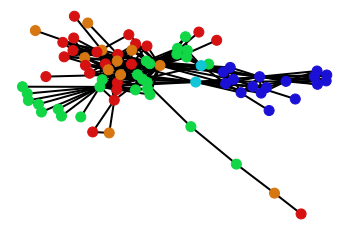

<Figure size 432x288 with 0 Axes>

In [51]:
cSymptom    = 5       # c, number of groups
TSymptom    = 30      # maximum number of phases; HALT if pc >= T
repsSymptom = 10      # number of repetitions of fit_DCSBM()

print("Network: Symptom Subgraph w/ Locally Greedy Heuristic Partition")
bestLLSymptom, bestZStarSymptom = fit_DCSBM_reps(symptomSubgraphInts, cSymptom, TSymptom, repsSymptom)
print("Log-Likelihood: ", max(bestLLSymptom))
wrs1Symptom, kr1Symptom = tabulate_wk(symptomSubgraphInts, bestZStarSymptom, cSymptom)
print("wrs Symtpom: ", wrs1Symptom,'\n', "kr Symptom: ", kr1Symptom)
drawGz(symptomSubgraphInts, bestZStarSymptom)
plt.savefig("symptomSubgraphDC-SBMGreedy.svg", format="svg")

### Disease Locally Greedy Heuristic Partition

Network: Disease Subgraph w/ Locally Greedy Heuristic Partition
 --> WE HAVE CONVERGENCE <-- 
Log-Likelihood:  -63479.60512005602
wrs Symtpom:  [[1.420e+02 9.800e+01 5.220e+02 1.340e+02 0.000e+00 1.070e+02]
 [9.800e+01 9.020e+02 3.000e+00 3.000e+01 0.000e+00 1.100e+01]
 [5.220e+02 3.000e+00 1.832e+03 1.000e+00 1.000e+00 3.100e+02]
 [1.340e+02 3.000e+01 1.000e+00 6.580e+02 0.000e+00 1.390e+02]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 7.840e+02 3.060e+02]
 [1.070e+02 1.100e+01 3.100e+02 1.390e+02 3.060e+02 1.120e+02]] 
 kr Symptom:  [1003. 1044. 2669.  962. 1091.  985.]


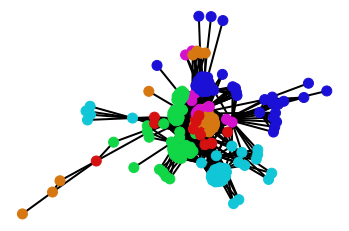

<Figure size 432x288 with 0 Axes>

In [52]:
cDisease    = 6       # c, number of groups
TDisease    = 30      # maximum number of phases; HALT if pc >= T
repsDisease = 1      # number of repetitions of fit_DCSBM()

print("Network: Disease Subgraph w/ Locally Greedy Heuristic Partition")
bestLLDisease, bestZStarDisease = fit_DCSBM_reps(diseaseSubgraphInts, cDisease, TDisease, repsDisease)
print("Log-Likelihood: ", max(bestLLDisease))
wrs1Disease, kr1Disease = tabulate_wk(diseaseSubgraphInts, bestZStarDisease, cDisease)
print("wrs Symtpom: ", wrs1Disease,'\n', "kr Symptom: ", kr1Disease)
drawGz(diseaseSubgraphInts, bestZStarDisease)
plt.savefig("diseaseSubgraphDC-SBMGreedy.svg", format="svg")

In [53]:
asdf

NameError: name 'asdf' is not defined

# Bipartite DC-SBM, more recent Larremore paper on block models (this code is old, please see https://github.com/behzodcu/eval-comm-detections-hsdn/tree/main/network/HSDN_biSBM)

In [ ]:
# Kernighan-Lin inference 

kl = KL(f_engine="engines/bipartiteSBM-KL/biSBM",
        n_sweeps=2,                                        # Note that this will generate <n_sweeps> output sub-folders in <f_kl_output>
        is_parallel=False,
        n_cores=2,
        kl_edgelist_delimiter="\t",                        # [KL] due to the KL code accepts 1-indexed nodes by default, we used the delimiter to transform our 0-indexed input.
        kl_steps=4,                                        # [KL] the number of random initializations (see the README_cplusplus.txt file)
        kl_itertimes=1,                                    # [KL] the number of KL runs (within each <outputFOLDER>) for returning an optimal result
        f_kl_output="engines/bipartiteSBM-KL/f_kl_output"  # [KL] path to the KL output dir; recommended to be in the same folder as the binary
    )

kl.prepare_engine("dataset/test/bisbm-n_1000-ka_4-kb_6.edgelist", 500, 500, 6, 7, delimiter="\t")

edgelist = get_edgelist("dataset/test/bisbm-n_1000-ka_4-kb_6.edgelist", "\t")
types = kl.gen_types(500, 500)

oks = OptimalKs(kl, edgelist, types)
oks.set_params(init_ka=10, init_kb=10, i_0=0.1)
oks.minimize_bisbm_dl()

print(oks.bookkeeping_mb["mcmc"][(4, 6)])

In [ ]:
# MCMC inference
n1 = 18
n2 = 14

mcmc = MCMC(f_engine="engines/bipartiteSBM-MCMC/bin/mcmc")

mcmc.prepare_engine("dataset/test/southernWomen.edgelist", 18, 14, 3, 2)
# Out[*]: 'engines/bipartiteSBM-MCMC/bin/mcmc -e dataset/test/southernWomen.edgelist -n 6 6 6 7 7 -t 1000000 -x 100000 -c abrupt_cool -a 100000.0 -y 18 14 -z 3 2 -E 0.001 -g

edgelist = get_edgelist("dataset/test/southernWomen.edgelist")
types = get_types("dataset/test/southernWomen.types")

types = mcmc.gen_types(n1, n2)  # n1=18 & n2=14

oks = OptimalKs(mcmc, edgelist, types)

oks.minimize_bisbm_dl()
# Out[*]:
# OrderedDict([((1, 1), 191.72536162138402),
#              ((6, 7), 227.47573446636372),
#              ((2, 1), 199.25454713207995),
#              ((1, 2), 197.11255878689138),
#              ((1, 3), 202.30070134785217),
#              ((2, 2), 199.5005556514051),
#              ((2, 3), 196.01966191156208),
#              ((3, 1), 203.69566837215007),
#              ((3, 2), 204.73016933010257),
#              ((3, 3), 201.34320240110824)])

oks.summary()
# Out[*]:
# {'algm_args': {'init_ka': 6, 'init_kb': 7, 'i_0': 0.058872511354072427},
#  'na': 18,
#  'nb': 14,
#  'e': 89,
#  'avg_k': 5.5625,
#  'ka': 1,
#  'kb': 1,
#  'mdl': 191.72536162138402,
#  'dl': {'adjacency': 108.99607644928233,
#   'partition': 5.5294290875114225,
#   'degree': 77.19985608459028,
#   'edges': 0.0}}

# Alternate Network Creation (Old Code)

In [ ]:
# Create network

Ghsdn = nx.from_pandas_edgelist(dfHSDN, 'MeSH Disease Term', 'MeSH Symptom Term', edge_key="TFIDF score",)

n = Ghsdn.number_of_nodes()
m = Ghsdn.number_of_edges()

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?

In [ ]:
#with_labels = 'True'
# plt.figure(figsize = (12, 6)) # Define new figure size because default figure produced turned out to be too smal
# hsdnLayoutGraph = nx.draw_spring(Ghsdn, with_labels = 'True', node_size = 500, font_color = 'black', node_color = 'blue') # Use nx.draw_spring to draw graph in spring layout. Use white on blue color scheme
# plt.show() # Show the layout itself after graph has been built

uniqueSymptom = sum(dfHSDN["MeSH Symptom Term"].value_counts())
print(uniqueSymptom)

print()

uniqueSymptomLabels = dfHSDN["MeSH Symptom Term"].unique()
print(uniqueSymptomLabels)

print()

uniqueDiseaseLabels = dfHSDN["MeSH Disease Term"].unique()
print(uniqueDiseaseLabels)
print(len(uniqueDiseaseLabels))
print(len(uniqueSymptomLabels))

In [ ]:
nx.is_connected(Ghsdn)
print(nx.number_connected_components(Ghsdn))
print(nx.node_connected_component(Ghsdn, 'Aging, Premature'))
print([len(c) for c in sorted(nx.connected_components(Ghsdn), key=len, reverse=True)])

In [ ]:
# Remove extraneous connected component

for component in list(nx.connected_components(Ghsdn)):
    if len(component) < 3:
        for node in component:
            Ghsdn.remove_node(node)

In [ ]:
# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(Ghsdn)
ellmean = compute_MGD(Ghsdn)
C = nx.transitivity(Ghsdn) 
h = nx.number_connected_components(Ghsdn)
degrees = [i[1] for i in Ghsdn.degree()]
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)